In [2]:
import pandas as pd
import numpy as np
import os
import itertools
from glob import glob

import matplotlib.pyplot as plt

# import tensorflow

## Setting configs


In [180]:
# Directory storing the CSI and WLAN captures
resources_dir = "/Volumes/tim_details/tim_honours/CAPTURES"

# Directory to save plots to
plt_dir = "/Users/timothylee/Desktop/Uni/Yr5/Honours/honours_thesis/figures/plt_figs/"

# Supress pd scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Resolution of plots
plt.rcParams["figure.dpi"] = 100 # 300
# plt.rcParams["figure.dpi"] = 500 # 300

# Backend to generate plots
# mpl.use("agg")
# %matplotlib ipympl
%matplotlib inline

# plt figure style
fig_style = "seaborn-v0_8-whitegrid"

# colormaps
cmap_qual = "pastel"
cmap_seq = "viridis"
cmap_cycl = "twilight"

# Hide warnings
import warnings
warnings.filterwarnings("ignore")


## Loading data

In [145]:
def ts_bin_df(df, interval, agg_dict):
    df = df.copy()
    # Generating time-bins
    time_series = df["frame.time_relative"]
    # If the df is empty (i.e. empty capture)
    if time_series.shape[0] == 0:
        return pd.DataFrame(columns=list(agg_dict.keys()))
    # Making list of bins
    bins = np.arange(
        0,
        np.ceil(time_series.max()) + interval,
        interval,
    )
    # Adding binned category column to data
    df["ts_bins"] = pd.cut(
        time_series,
        bins=bins,
        include_lowest=True,
        labels=bins[:-1],
    )

    # Grouping and aggregating data on time bins
    df_binned = df.groupby("ts_bins").agg(agg_dict)
    # Ensuring that there are all timebins (even if some rows are empty)
    df_binned = (
        df_binned
        .reset_index()
        .merge(pd.Series(bins, name="ts_bins"), on="ts_bins", how="right")
        .set_index("ts_bins")
        .sort_index()
    )
    return df_binned

def bin_filt_df(df, interval, agg_dict):
    # Initialising binned df
    df_binned = pd.DataFrame()
    # Making bins for each filter (direction, data/non-data frame):
    # Direction
    for d_k, d_v in {"up": (True,), "dn": (False,), "all": None}.items():
        # Frame Type: https://en.wikipedia.org/wiki/802.11_Frame_Types
        for fc_k, fc_v in {"ndat": (0, 1), "dat": (2,), "all": None}.items():
            # Filtering df
            df_f = df
            if d_v:
                df_f = df_f[df_f["is_upstream"].isin(d_v)]
            if fc_v:
                df_f = df_f[df_f["wlan.fc.type"].isin(fc_v)]
            # Making the binned df
            df_f_binned = ts_bin_df(df_f, interval, agg_dict)
            # Adding this filtered df to the total 
            df_binned = df_binned.merge(
                right=df_f_binned.add_suffix(f"_{d_k}_{fc_k}"),
                how="outer",
                left_index=True,
                right_index=True,
            )
    return df_binned

In [152]:
devices = {
    "client_pc_50": "PC 50 cm",
    "client_pc_200": "PC 200 cm",
    # "client_pc_200_wall": "PC 200 cm (wall)",
    # "client_pi_50":  "RPi4 50 cm",
    # "client_pi_200": "RPi4 200 cm",
    # "client_pi_200_wall": "RPi4 200 cm (wall)",
}
videos = {
    "v=A3gUpodXMv0": "Vid 1",
    "v=3InbMow9IYo": "Vid 2",
    # "v=mkWKZWMokdI": "Vid 3",
    # "v=t634q_Voeto": "Vid 4",
    # "v=w_oGIbFjiCo": "Vid 5",
    # "v=yve6qo6eowU": "Vid 6",
    # "v=gxxqdrrpgZc": "Vid 7",
    # "v=NSW5u1RTxEA": "Vid 8",
    # "v=t6jlhqNxRYk": "Vid 9",
}
labels = pd.DataFrame(columns=["devices", "videos"])
for i in itertools.product(devices, videos):
    labels.loc[len(labels)] = i


# Grouping and aggregating data on time bins
agg_dict = {
    "frames": "count", # #frames
    "bytes": "sum", # #bytes
}

# Making combined binned DF of all labels and instances
interval = 0.36 # Binning interval in seconds
X = pd.DataFrame()
# For each label combination
for i in labels.index:
    # Getting the particular label details
    row = labels.loc[i]
    print(row.values)
    # For reach capture in the label combination folder
    for fp in glob(os.path.join(resources_dir, row["devices"], row["videos"], "wlan_h5", "*.h5")):
        # Reading the wlan h5 file
        df = pd.read_hdf(
            os.path.join(fp),
            key="wlan",
            mode="r",
        )

        # Adding a column to track the frame count
        df["frames"] = np.arange(df.shape[0])
        # renaming columns
        df = df.rename(columns={"frame.len": "bytes"})
        # Binning df with different filters
        df_binned = bin_filt_df(df, interval, agg_dict)
        # Imputing missing values
        df_binned = df_binned.fillna(0)
        # Taking the first 500 bins (i.e. 180 seconds)
        df_binned = df_binned.iloc[:500]
        # Setting the ts_bins index as a column
        df_binned["ts_bins"] = df_binned.index

        # Adding label combo to group instances
        df_binned["devices"] = devices[row['devices']]
        df_binned["videos"] = videos[row['videos']]
        df_binned["instances"] = os.path.split(fp)[1]
        # Not including captures with less than 400 frames (i.e. invalid capture)
        if df_binned.shape[0] < 400:
            continue
        # Concatenating the instance's binned df to the overall binned df (df_all)
        X = pd.concat([X, df_binned], axis=0, ignore_index=True)
        break

# X.to_hdf(os.path.join(resources_dir, "total_mac.h5"), key="wlan", mode="w")

['client_pc_50' 'v=A3gUpodXMv0']
['client_pc_50' 'v=3InbMow9IYo']
['client_pc_200' 'v=A3gUpodXMv0']
['client_pc_200' 'v=3InbMow9IYo']


## ML Preprocessing

### Reading in total binned df

In [162]:
X = pd.read_hdf(os.path.join(resources_dir, "total_mac.h5"), key="wlan", mode="r")

### Formatting total binned df as features matrix

In [170]:
# # Removing labels from X DF
# X = X.drop(columns=["devices", "videos", "instances"])

# Using number of bytes as X feature vector
X_features = X["Bytes"]
X_features = (
    X_features
    .groupby(pd.MultiIndex.from_frame(X[["devices", "videos", "instances"]]))
    .apply(np.array)
)
X_features_matr = np.stack(X_features, axis=0)

# Setting y labels, because they can become reordered after the above groupby
Y = pd.MultiIndex.from_tuples(X_features.index, names=["devices", "videos", "instances"])


### Setting Y labels

In [175]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

# Using video as label
# TODO: can try out different combinations
y = Y.get_level_values("videos")

# Encode the labels
# le = LabelEncoder() # assigns integer encoding
lb = LabelBinarizer() # one-hot encoding
lb.fit(y)
y_lb = lb.transform(y)

### Processing X matrix

In [176]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer

# Converting the complex numbers to an array of 2D arrays with specified channels
X_features_matr_scaled = MinMaxScaler().fit_transform(X_features_matr)

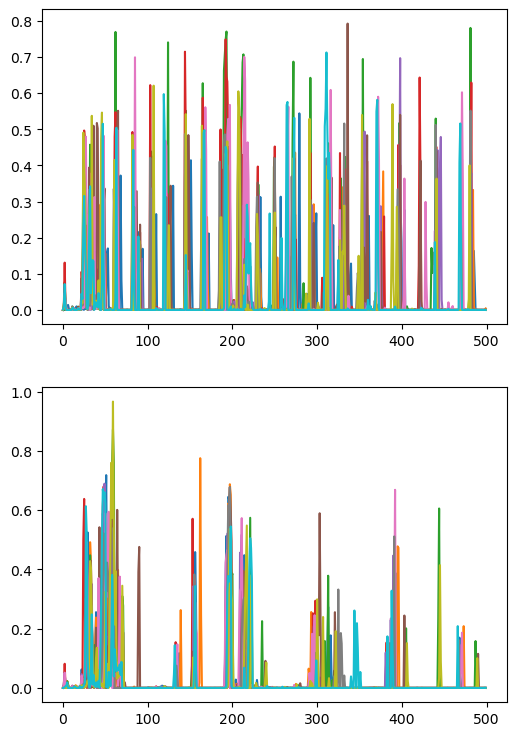

In [183]:
fig = plt.figure(figsize=(6, 9))
axes = fig.subplots(nrows=2, ncols=1)

axes[0].plot(X_features_matr_scaled[y == "Vid 1"][:5].T)
axes[1].plot(X_features_matr_scaled[y == "Vid 2"][:5].T)

In [184]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_features_matr_scaled,
    y_lb,
    test_size=0.2,
    random_state=42,
    stratify=y_lb,
)

# Flattening this data (reshaping) to feed into different ML algos
# X_train_flat = X_train.reshape(X_train.shape[0], -1)
# X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [185]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3859, 500)
(965, 500)
(3859, 9)
(965, 9)


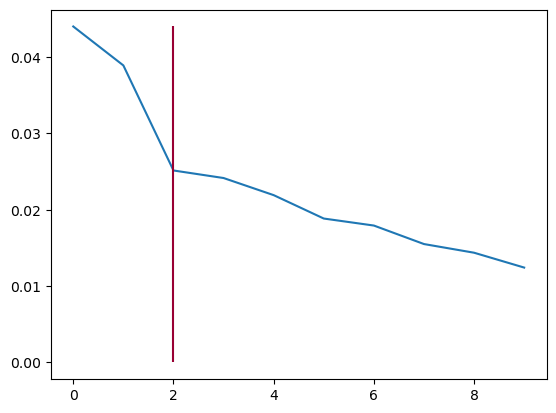

In [206]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PERFORMING PCA ANALYSIS (IN-CASE)
# Initialize and fit the PCA model
pca = PCA(n_components=10)
pca.fit(np.abs(X_train))

# Transform the data to the lower-dimensional space (and selecting only the top 3 components)
n_components = 2
X_train_pca = pca.transform(np.abs(X_train))[:, :n_components]
X_test_pca = pca.transform(np.abs(X_test))[:, :n_components]

plt.plot(pca.explained_variance_ratio_)
plt.vlines(x=n_components, ymin=0, ymax=pca.explained_variance_ratio_.max(), colors=(0.6,0,0.2))
plt.show()

In [207]:
# KNN WORKS VERY WELL!! Fast with PCA.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making KNN
knn = KNeighborsClassifier(
    n_neighbors=1,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None
)

# Training KNN
knn.fit(X_train, y_train)
# knn.fit(X_train_pca, y_train)

# Evaluating KNN
y_pred = knn.predict(X_test)
# y_pred = knn.predict(X_test_pca)

# Showing evaluation confusion matrix
cm = confusion_matrix(
    lb.inverse_transform(y_pred),
    lb.inverse_transform(y_test),
) # cols = actual, rows = predicted
print(cm)
print(classification_report(y_test, y_pred, target_names=lb.classes_))
print(accuracy_score(y_test, y_pred))


[[42  0 31  0  5  0  2  0  0]
 [ 2 61  1 22  3 13  3  3  6]
 [31  0 50  2  0  0  1  2  1]
 [ 3 26  7 68  9 20  2  2  2]
 [ 5  2  5  3 72  7  2  2  0]
 [ 2 17  0 10  5 61  3  5  2]
 [ 1  1  0  1  2  3 98  3  4]
 [ 0  1  3  3  0  1  4 95  3]
 [ 1  3  0  3  5  5  2  5 95]]
              precision    recall  f1-score   support

       Vid 1       0.53      0.48      0.50        87
       Vid 2       0.54      0.55      0.54       111
       Vid 3       0.57      0.52      0.54        97
       Vid 4       0.49      0.61      0.54       112
       Vid 5       0.73      0.71      0.72       101
       Vid 6       0.58      0.55      0.57       110
       Vid 7       0.87      0.84      0.85       117
       Vid 8       0.86      0.81      0.84       117
       Vid 9       0.80      0.84      0.82       113

   micro avg       0.67      0.67      0.67       965
   macro avg       0.66      0.66      0.66       965
weighted avg       0.67      0.67      0.67       965
 samples avg       0.67  

In [203]:
# SVM classifier with RBF. Not as fast or accurate as KNN
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making RBF SVM
svc = SVC(
    C=2.0, # Regularisation parameter. Reg strength is inversely proportional to C
    kernel='rbf', # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable
    # degree=3, # Degree for poly kernels
    gamma='scale', # {‘scale’, ‘auto’} or float
    coef0=0.0, # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
    shrinking=True, # Whether to use the shrinking heuristic
    probability=False, # Allows predict_proba but slows down process
    tol=0.001, # Tolerance for stopping criterion.
    cache_size=200, # Specify the size of the kernel cache in MB
    class_weight=None, # Set the parameter C of class i to class_weight[i]*C. Keep as none for equal weights across classes
    verbose=False, # Enable verbose output
    max_iter=-1, # Hard limit on iterations within solver, or -1 for no limit
    decision_function_shape='ovo', # {‘ovo’, ‘ovr’}
    break_ties=False,
    random_state=None
)
svc_mc = OneVsRestClassifier(svc)

# Training KNN
svc_mc.fit(X_train, y_train)
# svc_mc.fit(X_train_pca, y_train)

# Evaluating KNN
y_pred = svc_mc.predict(X_test)
# y_pred = svc_mc.predict(X_test_pca)

# Showing evaluation confusion matrix
cm = confusion_matrix(
    lb.inverse_transform(y_pred),
    lb.inverse_transform(y_test),
)
print(cm)
print(classification_report(y_test, y_pred, target_names=lb.classes_))
print(accuracy_score(y_test, y_pred))

[[75 50 47 56 44 63 28 36 26]
 [ 0 60  0  0  0  1  0  0  0]
 [12  0 49  0  0  0  0  0  0]
 [ 0  1  0 55  0  1  0  0  0]
 [ 0  0  1  0 57  0  0  0  0]
 [ 0  0  0  1  0 45  0  0  0]
 [ 0  0  0  0  0  0 89  0  0]
 [ 0  0  0  0  0  0  0 81  0]
 [ 0  0  0  0  0  0  0  0 87]]
              precision    recall  f1-score   support

       Vid 1       0.86      0.22      0.35        87
       Vid 2       0.98      0.54      0.70       111
       Vid 3       0.80      0.53      0.63        97
       Vid 4       0.96      0.49      0.65       112
       Vid 5       0.98      0.56      0.72       101
       Vid 6       0.94      0.41      0.57       110
       Vid 7       1.00      0.76      0.86       117
       Vid 8       1.00      0.69      0.82       117
       Vid 9       1.00      0.77      0.87       113

   micro avg       0.96      0.56      0.71       965
   macro avg       0.95      0.55      0.69       965
weighted avg       0.95      0.56      0.70       965
 samples avg       0.56  

In [223]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making MLP model with Entire CSI matrix.
model = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1], 1)),
    layers.Conv1D(8, 5, padding="valid", activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(16, (3,), padding="valid", activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(lb.classes_), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
    ],
)

# Show model architecture
model.summary()

# Training the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    verbose=True,
)

# Evaluating the model
y_pred = model.predict(X_test)
y_pred = tf.keras.utils.to_categorical(y_pred.argmax(axis=1), len(lb.classes_)).astype(int)

cm = confusion_matrix(
    lb.inverse_transform(y_pred),
    lb.inverse_transform(y_test)
)
print(cm)
# print(classification_report(y_test, y_pred, target_names=classes))
print(accuracy_score(y_test, y_pred))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 496, 8)            48        
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 248, 8)           0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 246, 16)           400       
                                                                 
 flatten_12 (Flatten)        (None, 3936)              0         
                                                                 
 dense_27 (Dense)            (None, 64)                251968    
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                     

In [216]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Making MLP model with PCA
model = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1], 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(lb.classes_), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        # tf.keras.metrics.Accuracy(),
        tf.keras.metrics.CategoricalAccuracy(),
    ],
)

# Show model architecture
# model.summary()

# Training the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    verbose=True,
)

# Evaluating the model
y_pred = model.predict(X_train)
y_pred = tf.keras.utils.to_categorical(y_pred.argmax(axis=1), len(lb.classes_)).astype(int)

cm = confusion_matrix(
    lb.inverse_transform(y_pred),
    lb.inverse_transform(y_train)
)
print(cm)
print(classification_report(y_train, y_pred, target_names=lb.classes_))
print(accuracy_score(y_train, y_pred))

Epoch 1/10
193/193 [==============================] - 1s 2ms/step - loss: 1.4877 - categorical_accuracy: 0.4056 - val_loss: 1.0158 - val_categorical_accuracy: 0.6049
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 1.0057 - categorical_accuracy: 0.5918 - val_loss: 0.8629 - val_categorical_accuracy: 0.6464
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 0.8817 - categorical_accuracy: 0.6395 - val_loss: 0.7796 - val_categorical_accuracy: 0.6969
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 0.7915 - categorical_accuracy: 0.6718 - val_loss: 0.7488 - val_categorical_accuracy: 0.7008
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 0.7436 - categorical_accuracy: 0.6851 - val_loss: 0.7317 - val_categorical_accuracy: 0.7008
Epoch 6/10
193/193 [==============================] - 1s 3ms/step - loss: 0.7078 - categorical_accuracy: 0.7123 - val_loss: 0.7266 - val_categorical_accuracy: 0.7021
Epoc

In [73]:
# Evaluating the model
y_pred = model.predict(X_test_pca)
y_pred = tf.keras.utils.to_categorical(y_pred.argmax(axis=1), len(lb.classes_)).astype(int)

cm = confusion_matrix(
    lb.inverse_transform(y_pred),
    lb.inverse_transform(y_test)
)
print(cm)
print(classification_report(y_test, y_pred, target_names=classes))
print(accuracy_score(y_test, y_pred))

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step
[[17  0  1  0  0  0]
 [ 0 19  0  0  0  0]
 [ 2  0 18  0  0  0]
 [ 0  0  0 18  1  0]
 [ 0  0  0  1 19  2]
 [ 0  0  0  1  0 18]]
                    precision    recall  f1-score   support

      client_pc_50       0.94      0.89      0.92        19
     client_pc_200       1.00      1.00      1.00        19
client_pc_200_wall       0.90      0.95      0.92        19
      client_pi_50       0.95      0.90      0.92        20
     client_pi_200       0.86      0.95      0.90        20
client_pi_200_wall       0.95      0.90      0.92        20

         micro avg       0.93      0.93      0.93       117
         macro avg       0.93      0.93      0.93       117
      weighted avg       0.93      0.93      0.93       117
       samples avg       0.93      0.93      0.93       117

0.9316239316239316
